<a href="https://colab.research.google.com/github/catalinapesquet/PINNS-Code-and-Notes/blob/main/PINNS_DiffusionEquation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries**

pyDOE is designed to help the scientist, engineer, statistician, etc., to construct appropriate experimental designs.: https://pythonhosted.org/pyDOE/

In [225]:
! pip install pyDOE

In [226]:
import torch
import torch.autograd as autograd # computation graph
from torch import Tensor # tensor node in the computation graph
import torch.nn as nn # neural networks
import torch.optim as optim # optimizers

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
from pyDOE import lhs # Latin Hypercube Sampling
import scipy.io

In [227]:
# Set default dtype to float32
torch.set_default_dtype(torch.float)

torch.manual_seed(1234)
np.random.seed(1234)

# Device agnostic code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda':
    print(torch.cuda.get_device_name())

cuda


## Parameters

In [228]:
# To generate new data:
x_min = -1
x_max = 1
t_min = 0
t_max = 1
total_points_x = 200
total_points_t = 100

#Nu: Number of training points
# Nf: Number of collocation points (Evaluate PDE)
Nu = 100
Nf = 10000

# **Auxiliary Functions**

In [229]:
def plot3D(x, t, y):
    # Prepare meshgrid and data
    x_plot = x.squeeze(1)
    t_plot = t.squeeze(1)
    T, X = torch.meshgrid(x_plot, t_plot, indexing='ij')
    F_xt = y

    # Convert to numpy
    T_numpy = T.numpy()
    X_numpy = X.numpy()
    F_xt_numpy = F_xt.numpy()

    # Check for invalid values
    if torch.isnan(F_xt).any() or torch.isinf(F_xt).any():
        F_xt = torch.nan_to_num(F_xt, nan=0.0, posinf=1e6, neginf=-1e6)

    # 2D Contour Plot
    fig, ax = plt.subplots(1, 1)
    cp = ax.contourf(T_numpy, X_numpy, F_xt_numpy, levels=20, cmap="rainbow")
    fig.colorbar(cp)
    ax.set_title('F(x,t)')
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    plt.show()

    # 3D Surface Plot
    ax = plt.axes(projection='3d')
    ax.plot_surface(T_numpy, X_numpy, F_xt_numpy, cmap="rainbow")
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.set_zlabel('f(x,t)')
    plt.show()


In [260]:
def plot3D_Matrix(x, t, y):
    # If x and t are 1D, create 2D grids using torch.meshgrid
    if len(x.shape) == 1 and len(t.shape) == 1:
        T, X = torch.meshgrid(t, x, indexing="ij")  # Generate 2D grids
    else:
        X, T = x, t  # Assume grids are already provided

    F_xt = y  # The function values F(x, t)

    # Convert tensors to numpy arrays for plotting with matplotlib
    if isinstance(T, torch.Tensor):
        T = T.detach().numpy()
    if isinstance(X, torch.Tensor):
        X = X.detach().numpy()
    if isinstance(F_xt, torch.Tensor):
        F_xt = F_xt.detach().numpy()

    # 2D Contour plot
    fig, ax = plt.subplots(1, 1)  # Create a 2D plot
    cp = ax.contourf(T, X, F_xt, 20, cmap="rainbow")  # Filled contour plot
    fig.colorbar(cp)  # Add a colorbar to the plot
    ax.set_title('F(x,t)')  # Add title
    ax.set_xlabel('t')  # Label for the t-axis
    ax.set_ylabel('x')  # Label for the x-axis
    plt.show()

    # 3D Surface plot
    fig = plt.figure()  # Create a new figure for 3D plotting
    ax = fig.add_subplot(111, projection='3d')  # Add 3D axes
    ax.plot_surface(T, X, F_xt, cmap="rainbow")  # 3D surface plot
    ax.set_xlabel('t')  # Label for the t-axis
    ax.set_ylabel('x')  # Label for the x-axis
    ax.set_zlabel('f(x,t)')  # Label for the z-axis
    plt.show()



Diffusion equation:
$$\frac{\partial y}{\partial t} =\frac{\partial^2 y}{\partial x^2}-e^{-t}(sin(\pi x)-\pi^2 sin(\pi x))$$

$$x\in[-1,1]$$
$$t\in[0,1]$$

Initial Condition
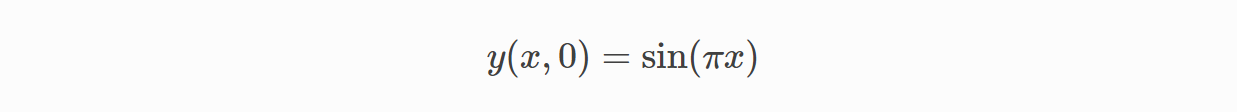
Boundary Conditions
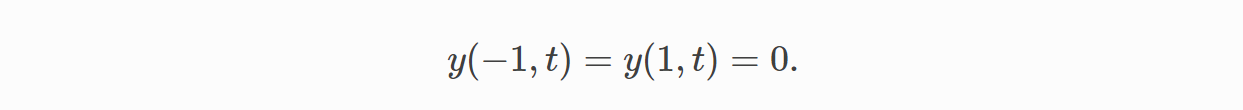
Exact solution (to evaluate the model)
$$y(x,t)=e^{-t}sin(\pi x)$$

# **Problem Setup**

## Analysis

## PDE
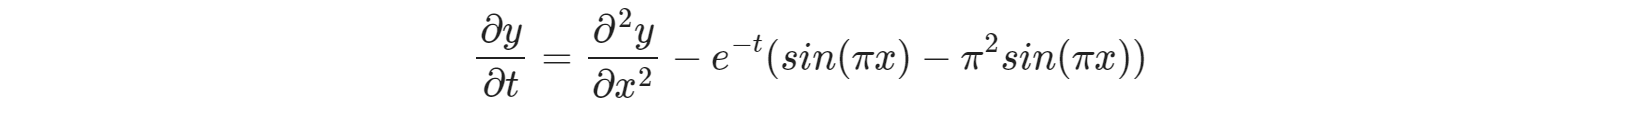
If we re arrange our PDE:
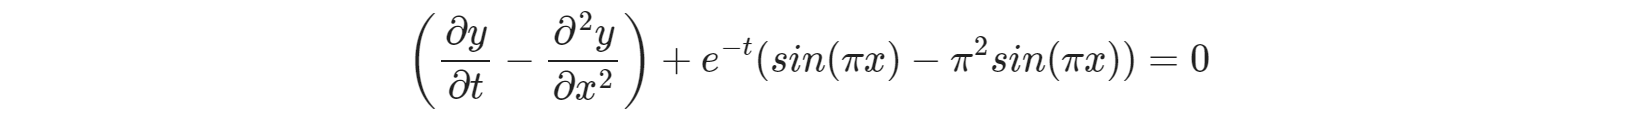

## Neural Network

A Neural Network is a function:
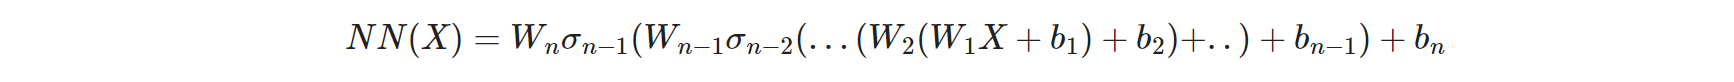

Assume:
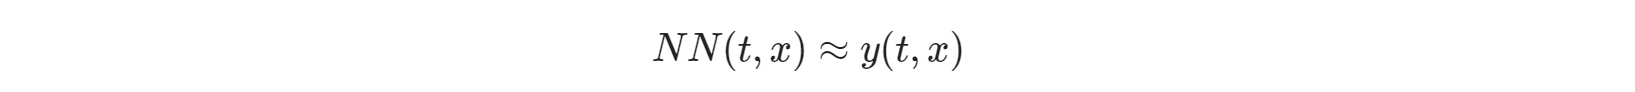

Then:
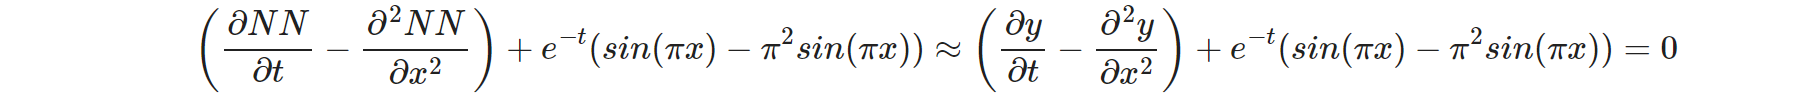

We define this function f:
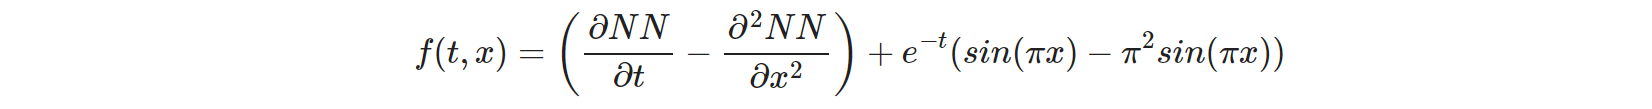

If $f$ -> 0, then our NN would be respecting the physical law.

## PDE Loss function

We evaluate our PDE in a certain number of "collocation points" $(Nf)$ inside our domain $(x,t)$
. Then we iteratively minimize a loss function related to $f$:
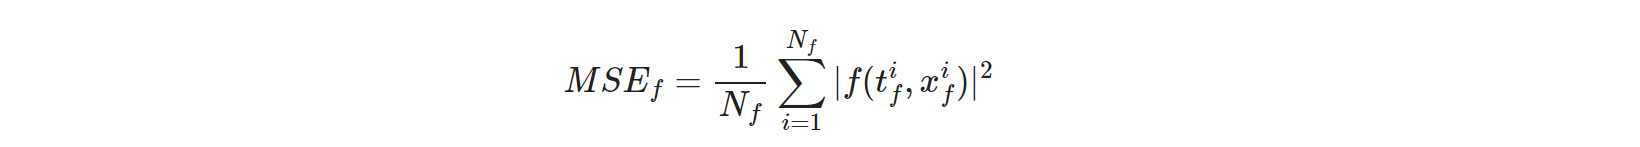

Usually, the training data set is a set of points from which we know the answer. In our case, we will use our boundary(BC) and initial conditions(IC).

### Initial condition
$y(x,0)=sin(\pi x)$

### Boundary Conditions
$y(-1,t)=0$

$y(1,t)=0$

Since we know the outcome, we select $Nu$ points from our BC and IC and used them to train our network.
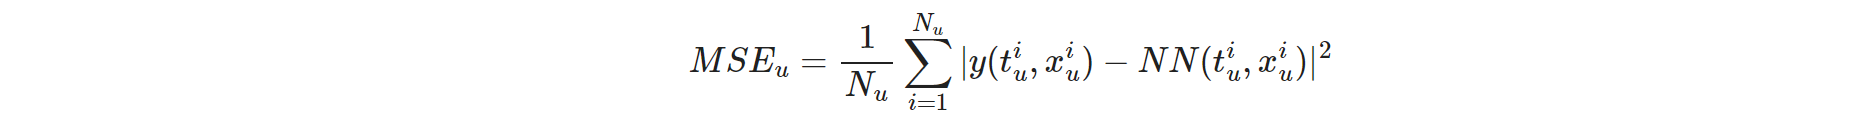

## Total Loss
Sum of loss from boundaries and loss from partial differential equation.
$MSE= MSEu + MSEf$



# **Generate and Visualize the DATA**

## Function

In [231]:
def f_real(x,t):
  return torch.exp(-t)*(torch.sin(np.pi*x))

## Generate data

In [232]:
x=torch.linspace(x_min,x_max,total_points_x).view(-1,1)
t=torch.linspace(t_min,t_max,total_points_t).view(-1,1)

## Create Mesh
Now let's generate a mesh using meshgrid: https://pytorch.org/docs/stable/generated/torch.meshgrid.html

In [233]:
# Create the mesh
X,T=torch.meshgrid(x.squeeze(1),t.squeeze(1))
# Evaluate real function
y_real=f_real(X,T)

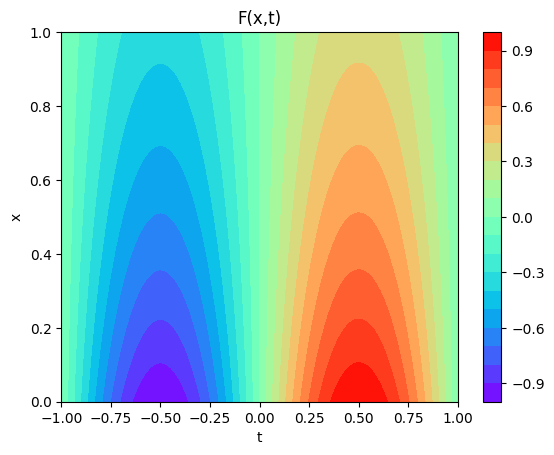

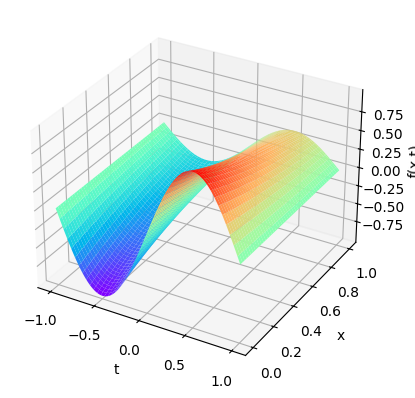

In [234]:
plot3D(x,t,y_real) #f_real was defined previously(function)

In [235]:
print(x.shape, t.shape, y_real.shape)
print(X.shape, T.shape)

torch.Size([200, 1]) torch.Size([100, 1]) torch.Size([200, 100])
torch.Size([200, 100]) torch.Size([200, 100])


# Testing Data

In [236]:
# Transform the mesh into a 2-column vector
x_test = torch.hstack((X.transpose(1,0).flatten()[:,None],T.transpose(1,0).flatten()[:,None]))
y_test=y_real.transpose(1,0).flatten()[:,None]

In [237]:
# Domain bounds
lb = x_test[0] # lower bound
ub = x_test[-1] # upper bound

print(x_test.shape,y_test.shape)
print(lb,ub)

torch.Size([20000, 2]) torch.Size([20000, 1])
tensor([-1.,  0.]) tensor([1., 1.])


# Training Data

Training data are boundary conditions

In [238]:
left_x = torch.hstack((X[:,0][:, None],T[:,0][:, None])) # all the rows and only first column
left_y = torch.sin(np.pi*left_x[:,0]).unsqueeze(1)

bottom_x = torch.hstack((X[-1,:][:,None],T[-1,:][:,None]))
bottom_y = torch.zeros(bottom_x.shape[0],1)

top_x = torch.hstack((X[0,:][:,None],T[0,:][:,None]))
top_y = torch.zeros(top_x.shape[0],1)

In [239]:
X_train = torch.vstack([left_x, bottom_x, top_x])
Y_train = torch.vstack([left_y, bottom_y, top_y])

Select a certain amount of points

In [240]:
Nu = 100 # 100 points from the boundary points
idx = np.random.choice(X_train.shape[0], Nu, replace=False)

X_train_Nu = X_train[idx,:]
Y_train_Nu = Y_train[idx,:]

Collocation points

In [241]:
Nf = 10000
X_train_Nf = lb + (ub-lb)*lhs(2,Nf)
X_train_Nf = torch.vstack((X_train_Nf, X_train_Nu))

In [242]:
X_train_Nu = X_train_Nu.float().to(device)
Y_train_Nu = Y_train_Nu.float().to(device)
X_train_Nf = X_train_Nf.float().to(device)
f_hat = torch.zeros(X_train_Nf.shape[0],1).to(device)

X_test = x_test.float().to(device)
Y_test = y_test.float().to(device)

# Neural Network

Here we use xavier normalisation to initiate the weights and ensure balanced activation propagation.. How does xavier works ? https://365datascience.com/tutorials/machine-learning-tutorials/what-is-xavier-initialization/


In [243]:
class FCN(nn.Module):
  def __init__(self, layers):
    super().__init__() # call __init__ from parent class
    'activation function'
    self.activation = nn.Tanh()
    'loss function'
    self.loss_function = nn.MSELoss(reduction='mean')
    'Initialise neural network as a list using nn.Modulelist to modify it later'
    self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])

    'Initialise our weights and bias'
    for i in range(len(layers)-1):
      # initialise weights with xavier normalisation
      nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
      # set bias to zero
      nn.init.zeros_(self.linears[i].bias.data)

  # passing through each layer and then activating it except the last layer
  def forward(self, x):
    if torch.is_tensor(x) != True:
      x = torch.from_numpy(x)
    a = x.float()
    for i in range(len(layers)-2):
      z = self.linears[i](a)
      a = self.activation(z)
    a = self.linears[-1](a) # computes the final output without applying the activation function
    return a

  # loss for boundary conditions
  def lossBC(self, x_BC, y_BC):
    loss_BC = self.loss_function(self.forward(x_BC), y_BC)
    return loss_BC

  # loss
  def lossPDE(self, x_PDE):
    g = x_PDE.clone()
    g.requires_grad = True # Enable differentiation
    f = self.forward(g)
    f_x_t = autograd.grad(f, g, torch.ones([g.shape[0], 1]).to(device),retain_graph=True, create_graph=True)[0] # first derivative
    f_xx_tt = autograd.grad(f_x_t, g, torch.ones(g.shape).to(device), create_graph=True)[0] # second derivative
    f_t=f_x_t[:,[1]]
    f_xx = f_xx_tt[:, [0]]
    f = f_t - f_xx + torch.exp(-g[:, 1:]) * (torch.sin(np.pi * g[:, 0:1]) - np.pi ** 2 * torch.sin(np.pi *g[:, 0:1]))
    return self.loss_function(f, f_hat)

  def loss(self, x_BC, y_BC, x_PDE):
    loss_bc = self.lossBC(x_BC, y_BC)
    loss_pde = self.lossPDE(x_PDE)
    return loss_bc + loss_pde

  # optimizer
  def closure(self):
      optimizer.zero_grad()  # clear gradients
      loss = self.loss(X_train_Nu,Y_train_Nu,X_train_Nf)
      loss.backward()      # back propagation
      self.iter += 1
      if self.iter % 100 == 0: # print every 100 iterations
        loss2=self.lossBC(X_test,Y_test)
        print("Training Error:",loss.detach().cpu().numpy(),"---Testing Error:",loss2.detach().cpu().numpy())
      return loss


# Training

In [244]:
# Parameters
epochs=20000
lr=1e-3
layers = np.array([2,32,64,1]) # hidden layers

In [245]:
PINN = FCN(layers)
PINN.to(device)
print(PINN)

FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)


Let's use Adam optimizer: really efficient when working with large problem involving a lot of data or parameters.

How Adam works?
*   Momentum: used to accelerate the gradient descent algorithm by taking into consideration the ‘exponentially weighted average’ of the gradients.
*   RMSP: adaptive learning algorithm that tries to improve AdaGrad. Instead of taking the cumulative sum of squared gradients like in AdaGrad, it takes the ‘exponential moving average’.
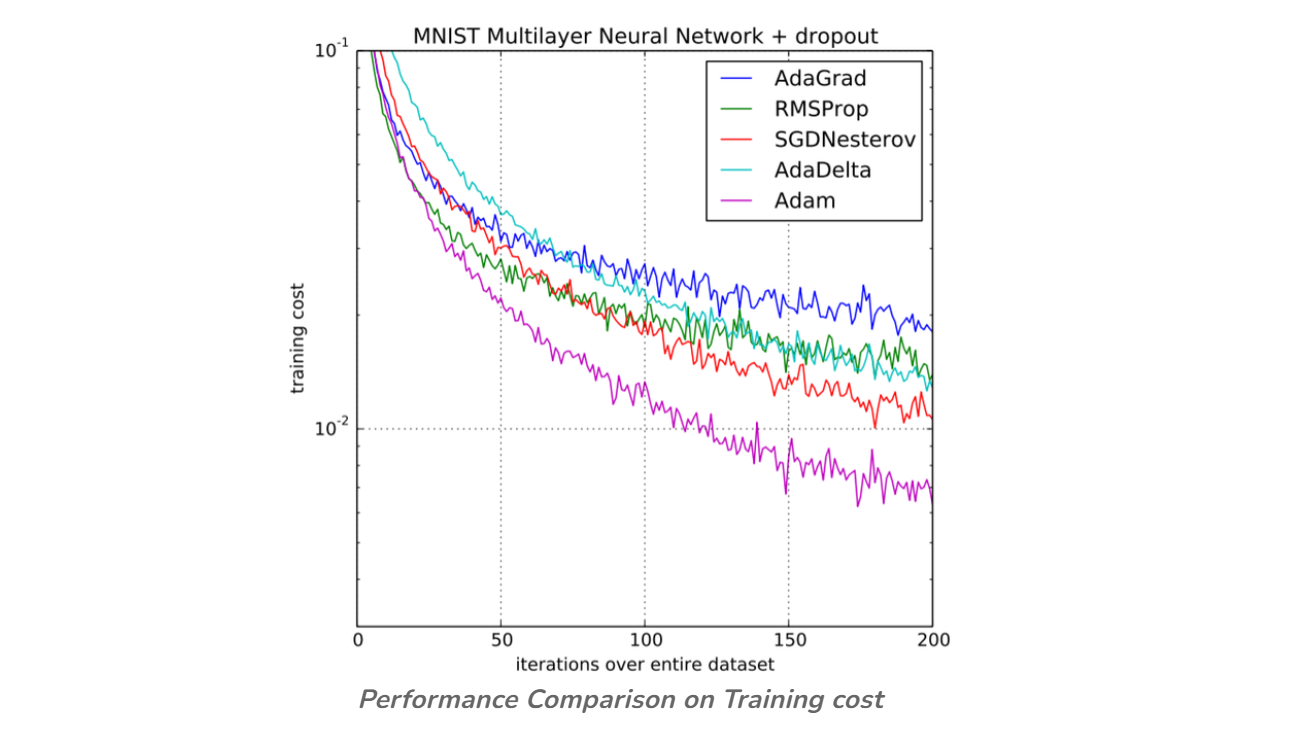

https://www.geeksforgeeks.org/adam-optimizer/

In [246]:
optimizer = torch.optim.Adam(PINN.parameters(), lr=lr, amsgrad=False)

In [247]:
# Initialiser des listes pour les losses
training_losses = []
testing_losses = []
epochs_to_plot = []

# Training loop
for epoch in range(epochs):
    # Compute training loss
    loss = PINN.loss(X_train_Nu, Y_train_Nu, X_train_Nf)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Stocker la loss d'entraînement
    training_losses.append(loss.item())

    # Compute and store testing loss every 200 epochs
    if epoch % 200 == 0:
        with torch.no_grad():
            test_loss = PINN.lossBC(X_test, Y_test)
        testing_losses.append(test_loss.item())
        epochs_to_plot.append(epoch)
        print(f'Epoch {epoch}: Training Loss = {loss.item()} / Testing Loss = {test_loss.item()}')


Epoch 0: Training Loss = 16.70165252685547 / Testing Loss = 0.17595379054546356
Epoch 200: Training Loss = 0.47183483839035034 / Testing Loss = 0.013730639591813087
Epoch 400: Training Loss = 0.18327200412750244 / Testing Loss = 0.028619786724448204
Epoch 600: Training Loss = 0.05264367535710335 / Testing Loss = 0.04807336628437042
Epoch 800: Training Loss = 0.02040727064013481 / Testing Loss = 0.04558739438652992
Epoch 1000: Training Loss = 0.010663099586963654 / Testing Loss = 0.04194162040948868
Epoch 1200: Training Loss = 0.007130582816898823 / Testing Loss = 0.04126185551285744
Epoch 1400: Training Loss = 0.0052885254845023155 / Testing Loss = 0.04057620093226433
Epoch 1600: Training Loss = 0.004194590263068676 / Testing Loss = 0.0400305837392807
Epoch 1800: Training Loss = 0.0034194719046354294 / Testing Loss = 0.03941620886325836
Epoch 2000: Training Loss = 0.002843013498932123 / Testing Loss = 0.03876025974750519
Epoch 2200: Training Loss = 0.0024222014471888542 / Testing Loss 

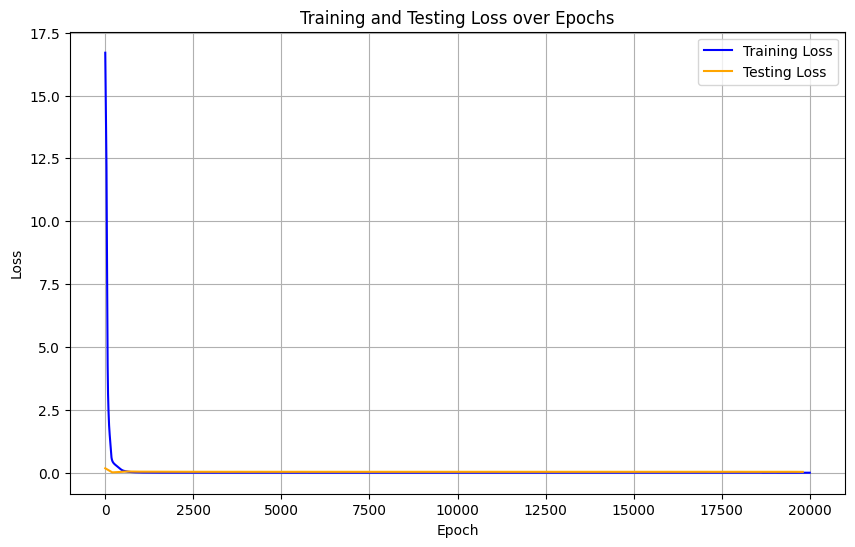

In [250]:
import matplotlib.pyplot as plt

# Tracer les courbes
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), training_losses, label='Training Loss', color='blue')
plt.plot(epochs_to_plot, testing_losses, label='Testing Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


# Results


In [251]:
y1 = PINN(X_test)
x1 = X_test[:,0]
t1 = X_test[:, 1]

In [254]:
arr_x1 = x1.reshape(shape=[100, 200]).transpose(1,0).detach().cpu()
arr_T1 = t1.reshape(shape=[100, 200]).transpose(1,0).detach().cpu()
arr_y1 = y1.reshape(shape=[100, 200]).transpose(1,0).detach().cpu()
arr_y_test = y_test.reshape(shape=[100, 200]).transpose(1,0).detach().cpu()

In [259]:
print("T shape:", T.shape)
print("X shape:", X.shape)
print("F_xt shape:", F_xt.shape)

T shape: torch.Size([200, 100])
X shape: torch.Size([200, 100])


NameError: name 'F_xt' is not defined

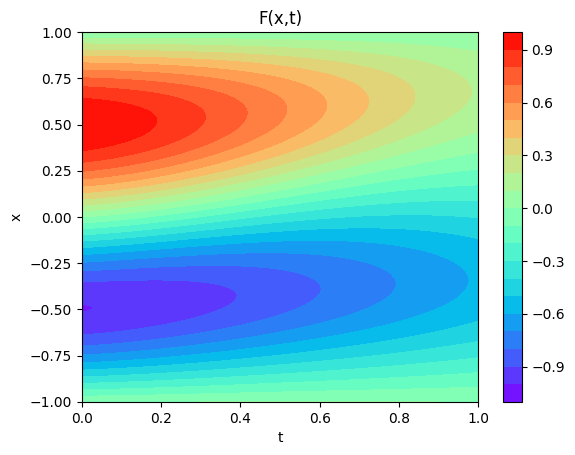

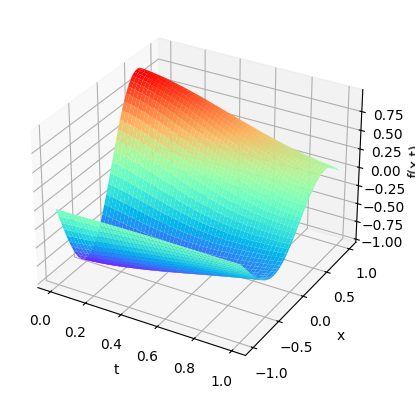

In [261]:
plot3D_Matrix(arr_x1, arr_T1, arr_y1)

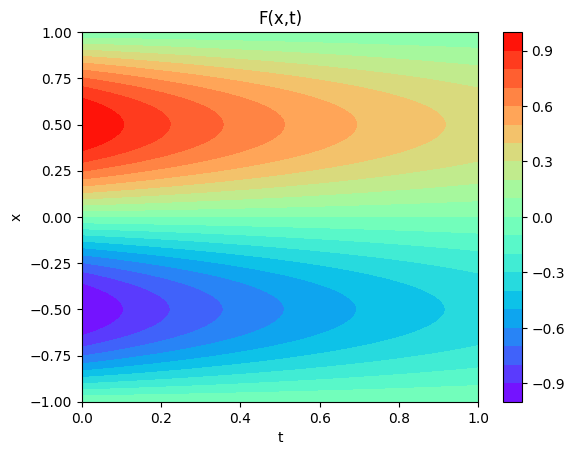

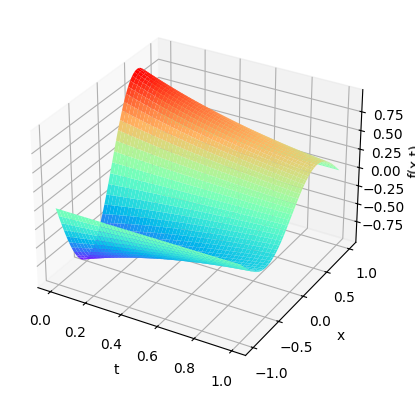

In [262]:
plot3D_Matrix(X, T, y_real)

We can see that our results obtain with the PINNs method are pretty close to the actual solution of the equation.

However if we want to improve the results we can always test other parameters (number of epochs, layer structure), optimizers etc...